# Segmentación Semantica de Carros

El propósito de este desarrollo es poder segmentar las diferentes partes de un carro


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Fri Oct 21 16:45:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q glob2
import glob2

In [ ]:
# Python ≥3.5 es requerido
import sys
assert sys.version_info >= (3, 5)

# Remover los warnings con el proposito de que el notebook sea mas limpio
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# importaciones comunes
import numpy as np
import pandas as pd
import os
import json

# hacer semilla para que los resultados sean reproducibles
np.random.seed(42)
SEED = 42

try:
    # %tensorflow_version Indicar que se esta usando la version 2.x de Tensorflow
    # solo existe en Colab
    %tensorflow_version 2.x
except Exception:
    pass


# TensorFlow ≥2.0 es requerido

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # remover los warnings de tensorflow
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# cargar el modulo de Tensorboard
%load_ext tensorboard

# Scikit-Learn ≥0.20 es requerido
import sklearn
assert sklearn.__version__ >= "0.20"

# OpenCV
import cv2

# para hacer graficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# para guardar las figuras
PROJECT_ROOT_DIR = "."
PROYECTO_ID = "EJERCICIO2"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROYECTO_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
class_name = ["background", "car", "wheel", "lights", "window"]

In [ ]:
DATASET_FILE_PATH = '/content/drive/MyDrive/UAO/dataset_cars.zip'
DATASET_DIR = os.path.join(PROJECT_ROOT_DIR,'dataset')
DATASET_FILE = os.path.join(DATASET_DIR,'dataset_cars.zip')
IMAGES_DIR = os.path.join(DATASET_DIR,'car-segmentation','images')
MASKS_DIR = os.path.join(DATASET_DIR,'car-segmentation','masks')
os.makedirs(DATASET_DIR, exist_ok=True)
if not os.path.isfile(DATASET_FILE):
  os.system(f'cp {DATASET_FILE_PATH} {DATASET_FILE} ')

In [ ]:
# unzip dataset
import zipfile
with zipfile.ZipFile(DATASET_FILE, 'r') as zip_ref:
    zip_ref.extractall(DATASET_DIR)

In [ ]:
# función para guardar las figuras
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Guardando figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def get_run_logdir(): return os.path.join(
    PROJECT_ROOT_DIR,
    "logs",
    PROYECTO_ID
)

In [ ]:
# función para graficar la pérdida
def graph_loss(history, name):
    plt.figure(figsize=(15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    save_fig(name)
    plt.show()

In [ ]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
# función para evaluar el error cuadrado entre los valores reales y los predichos
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    score = model.evaluate(X_test,y_test,verbose=0)
    print(f"El error cuadrado medio es: {mse}")
    print(f"El error absoluto medio es: {mae}")
    print(f"El coeficiente de determinación es: {r2}")
    print(f"Score: {score}")

## Pre Procesado de Datos

In [ ]:
class DataGenerator(keras.utils.Sequence):
    """
    Generador de Datos Semanticos a partir del Dataset Utilizado
    """

    def __init__(
        self,
        filename_list: list,
        input_size: tuple = (256, 256),
        batch_size: int = 1,
        shuffle: bool = True,
        seed: int = 42,
        color_mode='hsv',
        function=None,
        augment=False,
        **kwargs
    ):
        """
        Inicializacion del Generador de Datos Semanticos
        :param filename_list: Lista de tuplas de imagen y mascara
        :param input_size: Tamaño de Entrada de la Red
        :param batch_size: Tamaño del Batch
        :param shuffle: Si se debe Barajar los Datos
        :param seed: Semilla para Barajar los Datos
        :param color_mode: Modo de Color de las Imagenes
        :param function: Funcion de Preprocesamiento de las Imagenes
        :param augment: Si se debe Aplicar Data Augmentation
        :param kwargs: Argumentos de la Funcion de Preprocesamiento
        """
        super().__init__()
        assert color_mode == 'hsv' or color_mode == 'rgb' or color_mode == 'gray'
        self.filename_list = filename_list
        self.input_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.color_mode = color_mode
        self.function = function
        self.augment = augment
        self.kwargs = kwargs
        # set seed
        np.random.seed(self.seed)
        self.on_epoch_end()

    def __len__(self) -> int:
        """
        Numero de Batches por Epoca
        :return: Numero de Batches por Epoca
        """
        return int(len(self.filename_list) / self.batch_size)

    def __getitem__(self, index) -> tuple:
        """
        Obtencion de un Batch de Datos
        :param index: Indice del Batch
        :return: Tupla de Datos de Entrada y Salida
        """
        indexes = self.indexes[index * self.batch_size:
                               (index + 1) * self.batch_size]
        filename_list = [self.filename_list[k] for k in indexes]
        return self.__data_generation(filename_list)

    def on_epoch_end(self) -> None:
        """
        Acciones al Finalizar una Epoca
        """
        self.indexes = np.arange(len(self.filename_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, filename_list: list) -> tuple:
        """
        Generacion de un Batch de Datos
        :param filename_list: Lista de Rutas de Imagenes
        :return: Tupla de Datos de Entrada y Salida
        """
        # inicializacion de los datos
        x = np.empty((self.batch_size, *self.input_size, 3))
        y = np.empty((self.batch_size, *self.input_size, 1))
        # generacion de los datos
        for i, filename in enumerate(filename_list):
            # lectura de la imagen
            img = cv2.imread(filename[0])
            # cambiar dimensiones de la imagen
            img = cv2.resize(img, self.input_size)

            # conversion de la imagen a HSV
            if self.color_mode == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            # conversion de la imagen a RGB
            elif self.color_mode == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # conversion de la imagen a Escala de Grises
            elif self.color_mode == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.expand_dims(img, axis=-1)
            # aplicacion de la funcion de preprocesamiento
            if self.function is not None:
                img = self.function(img, **self.kwargs)
            # aplicacion de data augmentation
            if self.augment:
                img = self.__augment(img)
            # obtencion de la imagen de entrada
            # reshape img
            x[i, ] = img
            # obtencion de la imagen de salida
            y[i, ] = self.__get_mask(filename[1])
        return x, y

    def __augment(self, img: np.ndarray) -> np.ndarray:
        """
        Aplicacion de Data Augmentation a una Imagen
        :param img: Imagen a la que se le Aplicara Data Augmentation
        :return: Imagen con Data Augmentation Aplicada
        """
        # aplicacion de rotacion
        img = self.__rotate(img)
        # aplicacion de zoom
        img = self.__zoom(img)
        # aplicacion de flip
        img = self.__flip(img)
        return img

    def __rotate(self, img: np.ndarray) -> np.ndarray:
        """
        Aplicacion de Rotacion a una Imagen
        :param img: Imagen a la que se le Aplicara Rotacion
        :return: Imagen con Rotacion Aplicada
        """
        # obtencion de los angulos de rotacion
        angle = np.random.uniform(-10, 10)
        # aplicacion de la rotacion
        img = tf.keras.preprocessing.image.random_rotation(
            img, rg=angle, row_axis=0, col_axis=1, channel_axis=2
        )
        return img

    def __zoom(self, img: np.ndarray) -> np.ndarray:
        """
        Aplicacion de Zoom a una Imagen
        :param img: Imagen a la que se le Aplicara Zoom
        :return: Imagen con Zoom Aplicado
        """
        # obtencion de los rangos de zoom
        zoom_range = (0.9, 1.1)
        # aplicacion del zoom
        img = tf.keras.preprocessing.image.random_zoom(
            img, zoom_range=zoom_range, row_axis=0, col_axis=1, channel_axis=2
        )
        return img

    def __flip(self, img: np.ndarray) -> np.ndarray:
        """
        Aplicacion de Flip a una Imagen
        :param img: Imagen a la que se le Aplicara Flip
        :return: Imagen con Flip Aplicado
        """
        # aplicacion del flip
        img = tf.image.flip_left_right(img)
        return img

    def __get_mask(self, mask_filename: str) -> np.ndarray:
        """
        Obtencion de la Imagen de Salida
        :param filename: Ruta de la Imagen de Entrada
        :return: Imagen de Salida
        """
        # lectura de la imagen de salida
        mask = cv2.imread(mask_filename, cv2.IMREAD_GRAYSCALE)
        # cambiar dimensión de la máscara
        mask = cv2.resize(mask, self.input_size)
        mask = np.expand_dims(mask, axis=-1)
        return mask

In [ ]:
# abrir el dataset
images = glob2.glob(os.path.join(IMAGES_DIR,'*'))
masks = glob2.glob(os.path.join(MASKS_DIR,'*'))


data = list(zip(images, masks))
data = sklearn.utils.shuffle(data, random_state=SEED)
split = int(0.8 * len(data))

In [ ]:
# se obtiene una tupla de la imagen y su mascara
data[10]

('./dataset/car-segmentation/images/a594e4d7b37f6e9357ca3b92a4125262.png',
 './dataset/car-segmentation/masks/a594e4d7b37f6e9357ca3b92a4125262.png')

El dataset fue construido mediante el uso de la plataforma de [scale AI](https://scale.com/)

![](https://imgur.com/R6P7Fk3.png)

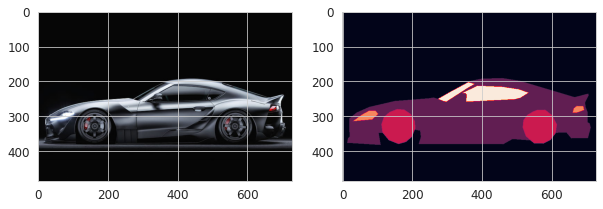

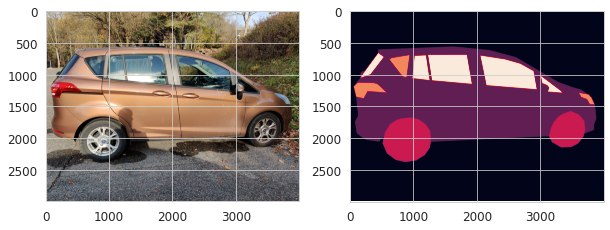

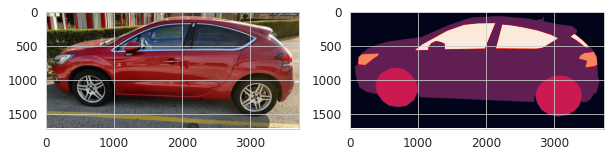

In [ ]:
# mostrar 3 primeras las imagenes
for i in range(3):
    fig, axs = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.set_figheight(25)
    img,lbl = data[i]
    img = plt.imread(img)
    lbl = plt.imread(lbl)
    axs[0].imshow(img)
    axs[1].imshow(lbl)
    plt.show()

In [ ]:
train_filename_list = data[:split]
valid_filename_list = data[split:]

In [ ]:
# Convertir lista de imágenes en secuencia de datos para poder ser entrenado
INPUT_SIZE = (256,256)
BATCH_SIZE = 32
SHUFFLE = True
AUGMENT = True

X_train = DataGenerator(
    train_filename_list,
    batch_size=16,
    augment=True
)

In [ ]:
X_valid = DataGenerator(
    valid_filename_list,
    batch_size=16,
    augment=True
)

## Entrenamiento del Modelo


## Arquitectura UNET

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import * 

leakyrelu_alpha = 0.3
dr_rate = 0.6
def unet(pretrained_weights=None, input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)    
    conv1 = LeakyReLU(alpha=leakyrelu_alpha)(conv1)
    #conv1 = Dropout(dr_rate)(conv1) ###
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(dr_rate)(pool1) ### 
    
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)
    #conv2 = Dropout(dr_rate)(conv2)###
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=leakyrelu_alpha)(conv2)    
    #conv2 = Dropout(dr_rate)(conv2)###    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=leakyrelu_alpha)(conv3)
    #conv3 = Dropout(dr_rate)(conv3) ###
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)    
    #conv4 = Dropout(dr_rate)(conv4) ###
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=leakyrelu_alpha)(conv4)
    drop4 = Dropout(dr_rate)(conv4) ###
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)    

    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)    
    conv5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #conv5 = Dropout(dr_rate)(conv5) ###
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = LeakyReLU(alpha=leakyrelu_alpha)(conv5)
    #drop5 = Dropout(dr_rate)(conv5) ###

    up6 = Conv2D(512, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU(alpha=leakyrelu_alpha)(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)
    #conv6 = Dropout(dr_rate)(conv6) ###
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = LeakyReLU(alpha=leakyrelu_alpha)(conv6)    
    #conv6 = Dropout(dr_rate)(conv6) ###   

    up7 = Conv2D(256, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    up7 = BatchNormalization()(up7)    
    up7 = LeakyReLU(alpha=leakyrelu_alpha)(up7)
    up7 = Dropout(dr_rate)(up7) ###
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)    
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)    
    #conv7 = Dropout(dr_rate)(conv7) ###
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = LeakyReLU(alpha=leakyrelu_alpha)(conv7)
    #conv7 = Dropout(dr_rate)(conv7) ###   

    up8 = Conv2D(128, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    up8 = BatchNormalization()(up8)
    up8 = LeakyReLU(alpha=0.3)(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = LeakyReLU(alpha=0.3)(conv8)
    #conv8 = Dropout(dr_rate)(conv8) ###
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)    
    conv8 = LeakyReLU(alpha=0.3)(conv8)    
    #conv8 = Dropout(dr_rate)(conv8) ###    

    up9 = Conv2D(64, 2, activation = None, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    up9 = BatchNormalization()(up9)
    up9 = LeakyReLU(alpha=leakyrelu_alpha)(up9)
    up9 = Dropout(dr_rate)(up9) ###
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)    
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = LeakyReLU(alpha=leakyrelu_alpha)(conv9)    
    #conv9 = Dropout(dr_rate)(conv9) ###
    conv10 = Conv2D(5, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
inp_size = (256, 256, 3)
model = unet(input_size=inp_size)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_52 (BatchN  (None, 256, 256, 64  256        ['conv2d_57[0][0]']              
 ormalization)                  )                                                           

In [ ]:
model_checkpoint = ModelCheckpoint('ejercicio.hdf5', monitor='loss', verbose=1, save_best_only=True)

In [ ]:
history = model.fit_generator(X_train, epochs=100, callbacks=[model_checkpoint],
                                  validation_data=X_valid)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 4.7183 - accuracy: 0.1403
Epoch 1: loss improved from inf to 4.71826, saving model to ejercicio.hdf5
10/10 [==============================] - 44s 3s/step - loss: 4.7183 - accuracy: 0.1403 - val_loss: 62.0154 - val_accuracy: 8.1778e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 4.8712 - accuracy: 0.1720
Epoch 2: loss did not improve from 4.71826
10/10 [==============================] - 30s 3s/step - loss: 4.8712 - accuracy: 0.1720 - val_loss: 90.1916 - val_accuracy: 0.0014
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 5.1085 - accuracy: 0.1672
Epoch 3: loss did not improve from 4.71826
10/10 [==============================] - 29s 3s/step - loss: 5.1085 - accuracy: 0.1672 - val_loss: 37.5671 - val_accuracy: 0.0119
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 5.2081 - accuracy: 0.1382
Epoch 4: loss did not improve from 4.71826
10/10 [===============

Guardando figura model_1_loss


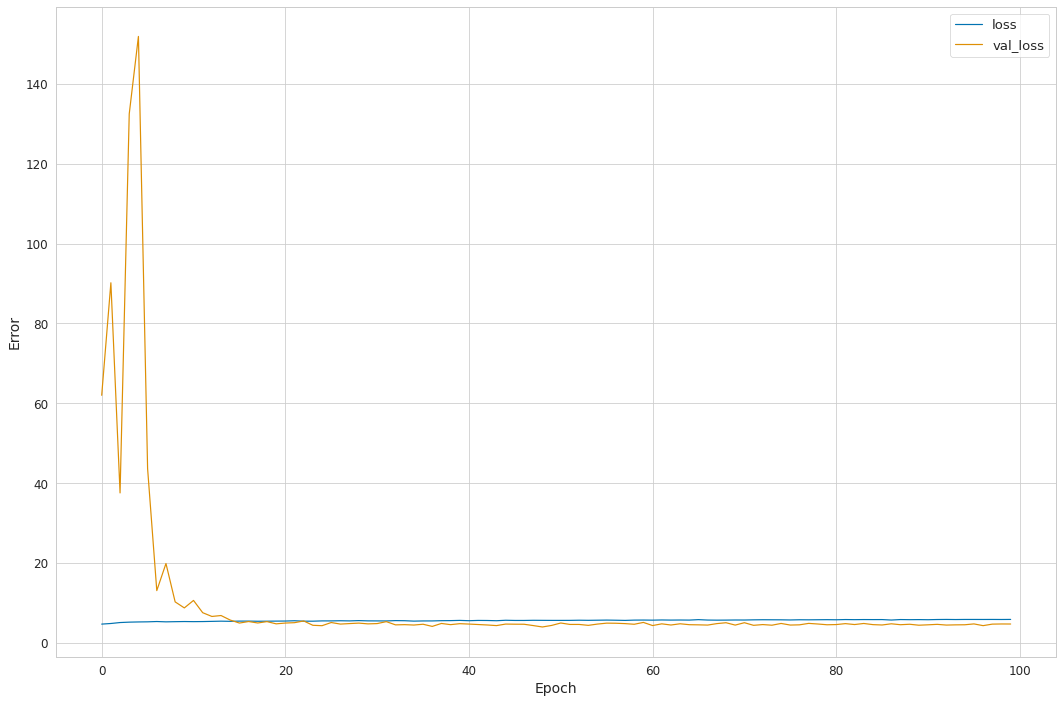

In [ ]:
graph_loss(history, "model_1_loss")

In [ ]:
result = model.predict_generator(X_valid, verbose=1)

2/2 [==============================] - 5s 2s/step


In [ ]:
valid_filename_list

[('./dataset/car-segmentation/images/anne-nygard-6t7wZAU3nuY-unsplash.png',
  './dataset/car-segmentation/masks/anne-nygard-6t7wZAU3nuY-unsplash.png'),
 ('./dataset/car-segmentation/images/im4.png',
  './dataset/car-segmentation/masks/im4.png'),
 ('./dataset/car-segmentation/images/IMG_20201123_135616.png',
  './dataset/car-segmentation/masks/IMG_20201123_135616.png'),
 ('./dataset/car-segmentation/images/676069.png',
  './dataset/car-segmentation/masks/676069.png'),
 ('./dataset/car-segmentation/images/im3.png',
  './dataset/car-segmentation/masks/im3.png'),
 ('./dataset/car-segmentation/images/IMG_20201123_143012.png',
  './dataset/car-segmentation/masks/IMG_20201123_143012.png'),
 ('./dataset/car-segmentation/images/Car.png',
  './dataset/car-segmentation/masks/Car.png'),
 ('./dataset/car-segmentation/images/IMG_20201123_144800.png',
  './dataset/car-segmentation/masks/IMG_20201123_144800.png'),
 ('./dataset/car-segmentation/images/2009-Ford-Kuga-Show-Car-Side-1280x960.png',
  './da

In [ ]:
import skimage.io as io
num_class = 5
Unlabelled = [0, 0, 0]
car = [255, 0, 0]
wheel = [120, 120, 120]
lights = [160, 160, 160]
window = [200, 200, 200]
COLOR_DICT = [Unlabelled, car, wheel, lights, window]
def labelVisualize(num_class, color_dict, img):
    img_out = np.zeros(img[:, :, 0].shape + (3,))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            index_of_class = np.argmax(img[i, j])
            img_out[i, j] = color_dict[index_of_class]
    return img_out

def saveResult(save_path, npyfile, image_list, flag_multi_class=True, num_class=num_class):
    count = 1
    for i, item in enumerate(npyfile):
        if flag_multi_class:
            img = labelVisualize(num_class, COLOR_DICT, item)
            img = img.astype(np.uint8)
            io.imsave(os.path.join(save_path,  f"{i}" + ".png"), img)
        else:
            img = item[:, :, 0]
            img[img > 0.5] = 1
            img[img <= 0.5] = 0
            img = img * 255.
            io.imsave(os.path.join(save_path , f"{i}" + ".png"), img)
        count += 1

In [ ]:
a = [ x[0] for x in valid_filename_list]

In [ ]:
saveResult('.', result,a, flag_multi_class=True, num_class=num_class)

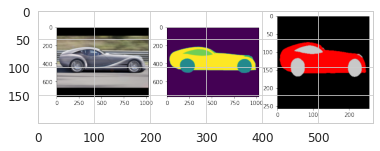

In [ ]:
for i in range(1):
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(10)
    fig.set_figheight(25)
    img,lbl = data[i]
    img = plt.imread(img)
    lbl = plt.imread(lbl)
    pred = plt.imread(f"{i}.png")
    axs[0].imshow(img)
    axs[1].imshow(lbl)
    axs[2].imshow(pred)
    plt.show()